# Reads the Synthetic Data and Does the Balanced Extraction

In [1]:
import JWS_SWOT_toolbox as swot
import pickle 
from datetime import datetime, timedelta
import numpy as np
import xarray as xr
from scipy.linalg import block_diag
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import cho_solve

%load_ext autoreload
%autoreload 2

In [2]:
### Read in our Pickles

with open("./pickles/karin_NA.pkl", "rb") as f:
    karin_NA = pickle.load(f)

with open("./pickles/nadir_NA.pkl", "rb") as f:
    nadir_NA = pickle.load(f)

with open("./pickles/karin.pkl", "rb") as f:
    karin = pickle.load(f)

with open("./pickles/nadir.pkl", "rb") as f:
    nadir = pickle.load(f)

### 1. Fit models to synthetic SWOT spectra


---- KaRIn spectrum parameters ----
Amp. balanced   :   1.5794e+05 ± 3.49e+03
lambda balanced :   3.0000e+02 ± 3.82e+00
slope balanced  :   4.7275e+00 ± 6.21e-02
Amp. noise      :   2.1402e+01 ± 4.34e+01
lambda noise    :   1.0000e+02 ± 1.57e+02
slope noise     :   1.3763e+00 ± 5.74e-02

---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 392.28906411678014 ± 1.66e+01


(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

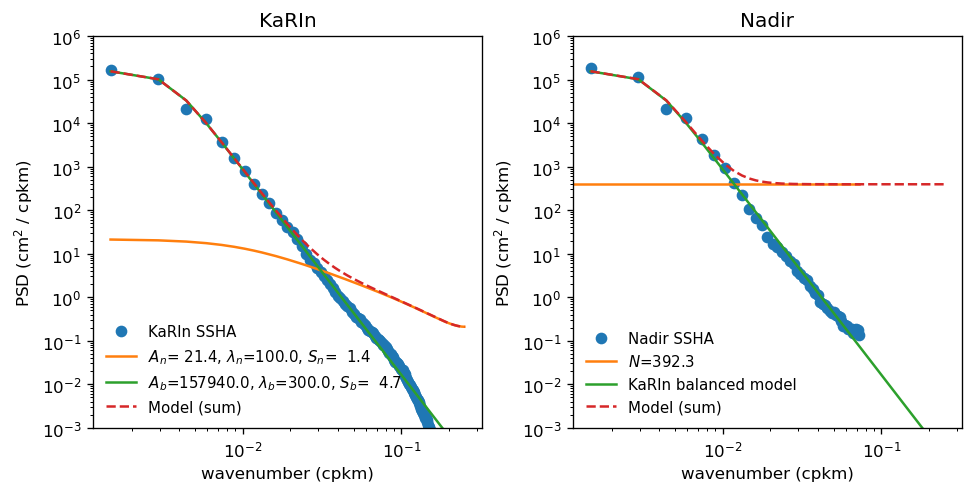

In [4]:
# KARIN
ntime = karin_NA.ssha.shape[0]
k_karin_NA = (karin_NA.wavenumbers_cpkm[int(karin_NA.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean_NA = karin_NA.spec_alongtrack_av[int(karin_NA.track_length/2):]

# noisy KaRIn spectrum
kt_NA_coords    = [np.arange(ntime), karin_NA.y_coord_km, karin_NA.x_coord_km]
ssh_noisy_xr = xr.DataArray(karin_NA.ssh_noisy * 100, coords = kt_NA_coords, dims = ['sample', 'line', 'pixel'])
spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin_NA.window, 'line', ['sample', 'pixel'])

# noisy Nadir Spectrum
nt_NA_coords    = [np.arange(ntime), nadir_NA.y_coord_km]
nad_noisy_xr = xr.DataArray(nadir_NA.ssh_noisy * 100, coords = nt_NA_coords, dims = ['sample', 'nadir_line'])
spec_nad_noisy = swot.mean_power_spectrum(nad_noisy_xr, nadir_NA.window, 'nadir_line', ['sample'])


# KaRIn model fit
poptcwg_karin_NA, pcovcwg_karin_NA = swot.fit_spectrum(karin_NA, spec_ssh_noisy, swot.karin_model)

# Nadir model fit
poptcwg_nadir_NA, covcwg_nadir_NA = swot.fit_nadir_spectrum(nadir_NA, spec_nad_noisy, poptcwg_karin_NA)

# Plot the fits
swot.plot_spectral_fits(karin_NA, nadir_NA, poptcwg_karin_NA, poptcwg_nadir_NA)

In [5]:
nx, ny = 2 * karin.swath_width, karin.track_length
nn = nadir.track_length
dx, dy, dn = karin.dx_km, karin.dy_km, nadir.dy_km

index = 72 # time index to estimate on 

# Create covariance functions
c = swot.balanced_covariance_func(poptcwg_karin_NA)
nk = swot.noise_covariance_func(poptcwg_karin_NA)

N_n = poptcwg_nadir_NA[0] # Nadir noise
sigma_n = np.sqrt(N_n / (2 * dn))

# Build masks
mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])

# Obs values from our measurement--- Since our spectra are fitted in cm, convert h to cm
h_obs = np.concatenate((
    100*karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
    100*nadir_NA.ssh_noisy[index][mask_n]
))

# Build covariance matrix grids in [km]
xkk = karin_NA.x_grid[mask_k].flatten(order="C")*1e-3
ykk = karin_NA.y_grid[mask_k].flatten(order="C")*1e-3
xnn = nadir_NA.x_grid.ravel()[mask_n]*1e-3
ynn = nadir_NA.y_grid.ravel()[mask_n]*1e-3

xobs = np.concatenate((xkk, xnn))
yobs = np.concatenate((ykk, ynn))

# Build covariance matrix from covariance functions
C_obs = swot.build_covariance_matrix(c, xobs, yobs)

# Build noise matrices
Nk_obs = nk(np.hypot(
    xobs[:len(xkk), None] - xobs[:len(xkk)],
    yobs[:len(xkk), None] - yobs[:len(xkk)]
))

Nn_obs = sigma_n**2 * np.eye(len(xnn))
N_obs = block_diag(Nk_obs, Nn_obs)

#build cholesky factor
cho_tuple = la.cho_factor(C_obs + N_obs, lower=True)

# target grids 
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin_NA, unit = 'km', extend = False) # we've flipped xt and yt so the grid align

# compute the covariance first 
R = c(np.hypot(xt[:, None] - xobs, yt[:, None] - yobs))

# Estimate signal
ht_NA_sim = swot.estimate_signal_on_target_cho_solve(R, cho_tuple, h_obs) # faster function

Variance from spectrum:   567.308389
Variance from covariance: 567.308389
Variance from spectrum:   0.527600
Variance from covariance: 0.527600
Calculating covariance matrices...
Estimating signal on target points (using cho_solve)...
Signal estimation time: 0.7075 seconds


In [6]:
# Posterior covariance, this takes some time 
import numpy as np
from scipy.linalg import solve

C_target = swot.build_covariance_matrix(c, xt, yt) # Covariance of my target matrix

#  P = C_target - R(C_obs + N_obs)⁻¹ @ R.T
print("Solving linear part")
#term = solve(C_obs + N_obs, R.T, assume_a='pos') # assume positive definite 
term = la.cho_solve(cho_tuple, R.T)

# 2. Posterior
print("posterior covariance matrix")
P = C_target - R @ term

# 3. Diagonal is posterior variance
posterior_variance = np.diag(P)

# 4. Reshape to target grid
posterior_variance_field = posterior_variance.reshape(nyt, nxt)
print("Done.")

Calculating covariance matrices...
Solving linear part
posterior covariance matrix
Done.


In [38]:
# First, spectrum of the mean estimate from balanced extraction 
ht_NA_2d = ht_NA_sim.reshape(nyt, nxt).T
ht_NA_coords = { 
    'pixel': np.arange(0.5, np.shape(ht_NA_2d)[0], 1.0) * karin.dy_km, 
    'line': np.arange(0.5, np.shape(ht_NA_2d)[1], 1.0) * karin.dx_km
    }

ht_map_xr = xr.DataArray(ht_NA_2d, coords = ht_NA_coords, dims = ['pixel', 'line'])
window_line = xr.DataArray(swot.sin2_window_func(np.shape(ht_NA_2d)[1]), dims=['line'], coords={'line': ht_map_xr['line']})
spec_ht_map = swot.mean_power_spectrum(ht_map_xr, window_line, 'line', ['pixel'])
bal_k = spec_ht_map.freq_line[int(karin.track_length/2):] 
spec_ht_map = 2 *spec_ht_map[int(karin.track_length/2):]

L = np.linalg.cholesky(P)

nreal = 20
half_idx = int(karin_NA.track_length // 2)
rng = np.random.default_rng(seed=42)

all_specs = [] # posterior spectra
all_specs_uncertainty = [] # uncertainties of the spectra 

for i in range(nreal):
    z = rng.standard_normal(len(P))
    eps = L @ z
    # posterior spectrum
    sample = ht_NA_sim + eps # we need to convert our fields back into cms since that's what the extraction is done in
    field2d = sample.reshape((nyt, nxt), order='C')
    da = xr.DataArray(
        (field2d)[None, :, :],
        coords=[[i], karin_NA.y_coord_km, karin_NA.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    
    spec_xr = swot.mean_power_spectrum(da, karin_NA.window, 'line', ['sample', 'pixel'])
    spec_vals =  2 * np.asarray(spec_xr).squeeze()
    
    if spec_vals.size == karin_NA.wavenumbers_cpkm.size:
        spec_1d = spec_vals[half_idx:]
    else:
        spec_1d = spec_vals
    all_specs.append(spec_1d)
    
    # Spectrum of the posterior uncertainty
    field2d_unc = eps.reshape((nyt, nxt), order='C')
    da_unc = xr.DataArray(
        (field2d_unc)[None, :, :],
        coords=[[i], karin_NA.y_coord_km, karin_NA.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr_unc = swot.mean_power_spectrum(da_unc, karin_NA.window, 'line', ['sample', 'pixel'])
    spec_vals_unc = 2 * np.asarray(spec_xr_unc).squeeze()
    
    if spec_vals_unc.size == karin_NA.wavenumbers_cpkm.size:
        spec_1d_unc = spec_vals_unc[half_idx:]
    else:
        spec_1d_unc = spec_vals_unc
    
    all_specs_uncertainty.append(spec_1d_unc)

all_spectra = np.array(all_specs)
spec_mean = np.nanmean(all_spectra, axis=0)
spec_std = np.nanstd(all_spectra, axis=0)
spec_median = np.nanmedian(all_spectra, axis=0)
spec_mean_uncertainty = np.nanmean(np.array(all_specs_uncertainty), axis=0)

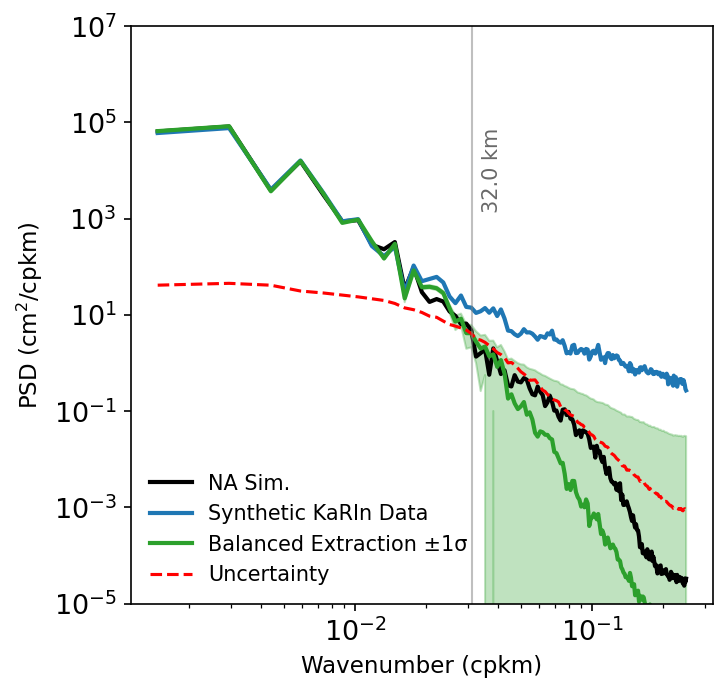

In [43]:
# Plot Spectrum of the Extraction we will also now overlay the Eulerian filtered field spectra

k_karin_NA = (karin_NA.wavenumbers_cpkm[int(karin_NA.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean_NA = 2*karin_NA.spec_alongtrack_av[int(karin_NA.track_length/2):]

spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin_NA.window, 'line', ['sample', 'pixel'])
spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr[index, :, :], karin_NA.window, 'line', ['pixel'])
spec_ssh_noisy_half = 2*spec_ssh_noisy[int(karin.track_length/2):] # take the half spectrum

ssha_full_xr = xr.DataArray(karin_NA.ssha_full[index, :, :][:, 4:64].T*100, coords = ht_NA_coords, dims = ['pixel', 'line'])
spec_NA_ins = swot.mean_power_spectrum(ssha_full_xr, karin_NA.window, 'line', ['pixel'])
spec_NA_ins_half = 2*spec_NA_ins[int(karin.track_length/2):] # take the half spectrum

y_error = np.sqrt(spec_mean_uncertainty)

fig, ax = plt.subplots(figsize=(5,5), dpi=150)

k_km = karin_NA.wavenumbers_cpkm[int(karin.track_length/2):]   # wavenumbers in km for plotting

ax.loglog(k_km[1:], spec_NA_ins_half[1:], 'k-', lw=2, label='NA Sim.')
ax.loglog(k_km[1:], spec_ssh_noisy_half[1:], '-', lw=2, label='Synthetic KaRIn Data')

ax.loglog(bal_k[1:], spec_ht_map[1:], color='tab:green', lw=2, label='Balanced Extraction ±1σ')
ax.fill_between(bal_k[1:], 
                spec_ht_map[1:] - y_error[1:], 
                spec_ht_map[1:] + y_error[1:], 
                color='tab:green', 
                alpha=0.3)
plt.loglog(k_km[1:], spec_mean_uncertainty[1:],'r--', label = 'Uncertainty')
# ax.loglog(bal_k[1:], spec_ht_map[1:], color='tab:green', lw=2, label='Balanced Extraction')
# ax.errorbar(bal_k[1:], spec_mean[1:], yerr=spec_std[1:], fmt='-', lw=2, ms=3,
#             elinewidth=1, capsize=3, label='Posterior Sample Mean ±1σ')
# plt.loglog(k_km[1:], karin_spec_sample_mean_NA[1:],'k--', label = 'NA Sim Mean')

separation_scale_km = 32
separation_wavenumber = 1/separation_scale_km 
ax.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
text_label = f'{separation_scale_km:.1f} km'
ymin, ymax = ax.get_ylim()
y_pos = 1e4
ax.text(separation_wavenumber * 1.1, y_pos, text_label,
            rotation=90,          # Rotate text to be vertical
            color='dimgrey',      # A slightly darker grey for readability
            fontsize=10,
            verticalalignment='center',
            horizontalalignment='left')

ax.set_xlabel('Wavenumber (cpkm)', fontsize=11)
ax.set_ylabel('PSD (cm$^2$/cpkm)', fontsize=11)
ax.legend(loc='lower left', frameon=False)
ax.set_ylim(1e-4, 1e6)
# ↓ correct way to skip every other y-tick
yticks = ax.get_yticks()
ax.set_yticks(yticks[::2])

ax.tick_params(axis='both', which='major', labelsize=13)
fig.savefig('synth_extraction_spec.pdf', bbox_inches='tight')

The spectra separate at a spatial scale of 23.1 km.
At scales smaller than this, the balanced extraction retains less than 50% of the original signal power.


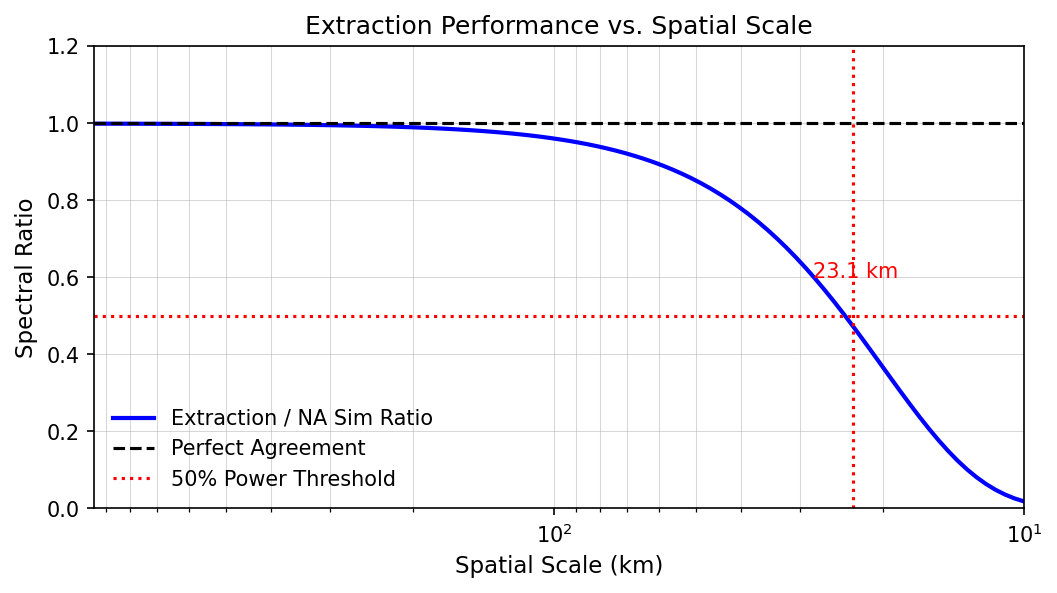

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Create some plausible-looking dummy data for demonstration
# In a real scenario, these variables would be loaded or calculated
wavenumbers_full = np.logspace(-3, -1, 100) # from 1000 km to 10 km scale
k_km = wavenumbers_full
# A simulated spectrum that falls off with wavenumber
spec_NA_ins_half = 1e-4 * wavenumbers_full**(-2)
# An "extracted" spectrum that falls off more sharply, simulating a filter
spec_ht_map = spec_NA_ins_half * np.exp(-(wavenumbers_full / 0.05)**2)


# --- Analysis Setup ---
# Ensure consistent array lengths by slicing
wavenumbers = k_km[1:]
# Calculate spatial scales in km. This will be our new x-axis.
scales_km = 1 / wavenumbers
sim_spectrum = spec_NA_ins_half[1:]
extraction_spectrum = spec_ht_map[1:]

# Calculate the ratio of the two spectra
spectral_ratio = extraction_spectrum / sim_spectrum

# Define the threshold for separation
separation_threshold = 0.5

# Find the first index where the ratio drops below the threshold
separation_indices = np.where(spectral_ratio < separation_threshold)[0]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

# Plot the spectral ratio against the spatial scale
ax.plot(scales_km, spectral_ratio, color='blue', lw=2, label='Extraction / NA Sim Ratio')

# Add a horizontal line at y=1 for perfect agreement
ax.axhline(y=1.0, color='k', linestyle='--', lw=1.5, label='Perfect Agreement')

# --- Quantify and Annotate the Separation Scale ---
if separation_indices.size > 0:
    first_separation_index = separation_indices[0]
    # The separation scale is directly obtained from our new x-axis array
    separation_scale_km = scales_km[first_separation_index]

    # Add a horizontal line for the threshold
    ax.axhline(y=separation_threshold, color='red', linestyle=':', lw=1.5,
               label=f'{separation_threshold*100:.0f}% Power Threshold')

    # Add a vertical line marking the separation scale
    ax.axvline(x=separation_scale_km, color='red', linestyle=':', lw=1.5)

    # Add text to the plot to clearly label the scale
    # We place the text at a slightly larger scale (to the left on the plot)
    ax.text(separation_scale_km * 0.8, 0.6,
            f'\n{separation_scale_km:.1f} km',
            color='red', fontsize=10, ha='right') # horizontal alignment to the right

    print(f"The spectra separate at a spatial scale of {separation_scale_km:.1f} km.")
    print(f"At scales smaller than this, the balanced extraction retains less than {separation_threshold*100:.0f}% of the original signal power.")

else:
    print(f"The spectral ratio never dropped below the threshold of {separation_threshold}.")


# --- Formatting ---
ax.set_xscale('log')
ax.set_yscale('linear')

# Update the x-axis label
ax.set_xlabel('Spatial Scale (km)', fontsize=11)
ax.set_ylabel('Spectral Ratio', fontsize=11)
ax.set_title('Extraction Performance vs. Spatial Scale', fontsize=12)
ax.legend(frameon=False)
ax.grid(True, which='both', linestyle='-', linewidth=0.5, alpha = 0.5)

ax.set_ylim(0, 1.2) # Adjusted ylim for better visualization
# Set x-limits to match the data range, noting that smaller scales are now on the right
ax.set_xlim(scales_km[-1], scales_km[0])

# Invert the x-axis so that larger scales (e.g., 1000 km) are on the left
ax.invert_xaxis()

ax.tick_params(axis='both', which='major', labelsize=10)
fig.savefig('quantified_separation_scale.pdf', bbox_inches='tight')

In [120]:
# ==============================================================================
# Find the spatial scale where the NA Sim separates from the Balanced Extraction
# ==============================================================================

# Define the separation threshold (e.g., a factor of 2)
# This means we look for the point where one spectrum is twice the value of the other.
separation_threshold = 10

# We will ignore the first data point (k=0) as is done in the plot
wavenumbers_to_check = k_km[1:]
na_sim_psd = spec_NA_ins_half[1:]
balanced_psd = spec_ht_map[1:]

# Calculate the ratio of the two spectra
# Add a small epsilon to the denominator to avoid division by zero errors
epsilon = 1e-20
ratio = na_sim_psd / (balanced_psd + epsilon)

# Find the first index where the ratio goes outside the bounds [1/threshold, threshold]
# This corresponds to the first point of significant separation.
try:
    # The np.where() function returns a tuple of arrays; we need the first element of the first array.
    separation_index = np.where((ratio > separation_threshold) | (ratio < 1/separation_threshold))[0][0]

    # Get the wavenumber at this separation point
    separation_wavenumber = wavenumbers_to_check[separation_index]

    # Convert the wavenumber (in cycles per km) to a spatial scale (in km)
    separation_scale_km = 1 / separation_wavenumber

    print("\n" + "="*50)
    print("Separation Scale Calculation")
    print("="*50)
    print(f"The NA simulation separates from the balanced extraction line at:")
    print(f"  -> Wavenumber (k): {separation_wavenumber:.3f} cpkm")
    print(f"  -> Spatial Scale (λ = 1/k): {separation_scale_km:.1f} km")
    print("="*50 + "\n")

except IndexError:
    # This will happen if the curves never separate by the defined threshold
    print("\nCould not find a separation point for the given threshold of "
          f"{separation_threshold}x.\n")



Separation Scale Calculation
The NA simulation separates from the balanced extraction line at:
  -> Wavenumber (k): 0.059 cpkm
  -> Spatial Scale (λ = 1/k): 17.0 km



### Compute the posterior covariances for doing the error checking

In [19]:
from scipy.linalg import solve, cholesky
import scipy.sparse as sp

def laplacian_operator(ny, nx, dx, dy):
    """
    Computes a 2D Laplacian using second-order accurate schemes.
    - Central difference for the interior.
    - Second-order one-sided (forward/backward) differences for the boundaries.
    """
    N = ny * nx
    L = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    # Coefficients for brevity
    cx = 1 / dx**2
    cy = 1 / dy**2

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # X-contribution to the Laplacian
            if i == 0:
                # 2nd-order forward difference for 2nd derivative
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i + 1, j)] += -5 * cx
                L[k, idx(i + 2, j)] +=  4 * cx
                L[k, idx(i + 3, j)] += -1 * cx
            elif i == nx - 1:
                # 2nd-order backward difference for 2nd derivative
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i - 1, j)] += -5 * cx
                L[k, idx(i - 2, j)] +=  4 * cx
                L[k, idx(i - 3, j)] += -1 * cx
            else:
                # 2nd-order central difference for 2nd derivative
                L[k, idx(i - 1, j)] +=  1 * cx
                L[k, idx(i, j)]     += -2 * cx
                L[k, idx(i + 1, j)] +=  1 * cx

            # Y-contribution to the Laplacian
            if j == 0:
                # 2nd-order forward difference
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j + 1)] += -5 * cy
                L[k, idx(i, j + 2)] +=  4 * cy
                L[k, idx(i, j + 3)] += -1 * cy
            elif j == ny - 1:
                # 2nd-order backward difference
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j - 1)] += -5 * cy
                L[k, idx(i, j - 2)] +=  4 * cy
                L[k, idx(i, j - 3)] += -1 * cy
            else:
                # 2nd-order central difference
                L[k, idx(i, j - 1)] +=  1 * cy
                L[k, idx(i, j)]     += -2 * cy
                L[k, idx(i, j + 1)] +=  1 * cy

    return L.tocsr()
    
def gradient_operator(ny, nx, dx, dy):
    """
    Computes gradient operators Gx and Gy using second-order accurate schemes.
    - Central difference for the interior.
    - Second-order one-sided (forward/backward) differences for the boundaries.
    """
    N = ny * nx
    Gx = sp.lil_matrix((N, N))
    Gy = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # Gx operator (derivative with respect to x)
            if i == 0:
                # 2nd-order forward difference at the left edge
                Gx[k, idx(i, j)]     = -1.5 / dx
                Gx[k, idx(i + 1, j)] =  2.0 / dx
                Gx[k, idx(i + 2, j)] = -0.5 / dx
            elif i == nx - 1:
                # 2nd-order backward difference at the right edge
                Gx[k, idx(i, j)]     =  1.5 / dx
                Gx[k, idx(i - 1, j)] = -2.0 / dx
                Gx[k, idx(i - 2, j)] =  0.5 / dx
            else:
                # 2nd-order central difference for the interior
                Gx[k, idx(i - 1, j)] = -0.5 / dx
                Gx[k, idx(i + 1, j)] =  0.5 / dx

            # Gy operator (derivative with respect to y)
            if j == 0:
                # 2nd-order forward difference at the bottom edge
                Gy[k, idx(i, j)]     = -1.5 / dy
                Gy[k, idx(i, j + 1)] =  2.0 / dy
                Gy[k, idx(i, j + 2)] = -0.5 / dy
            elif j == ny - 1:
                # 2nd-order backward difference at the top edge
                Gy[k, idx(i, j)]     =  1.5 / dy
                Gy[k, idx(i, j - 1)] = -2.0 / dy
                Gy[k, idx(i, j - 2)] =  0.5 / dy
            else:
                # 2nd-order central difference for the interior
                Gy[k, idx(i, j - 1)] = -0.5 / dy
                Gy[k, idx(i, j + 1)] =  0.5 / dy

    return Gx.tocsr(), Gy.tocsr()

# Physical constants
g = 9.81
omega = 7.2921e-5
eps_f = 1e-12

# Coriolis parameter
# mean latitude scalar (simple)
mean_lat_deg = float(np.nanmean(karin.lat[index,:,:]))
lat_rad = np.deg2rad(mean_lat_deg)
f = 2.0 * omega * np.sin(lat_rad)
if abs(f) < eps_f:
    f = np.sign(f) * eps_f if f != 0 else eps_f

# Build linear operators
Gx, Gy = gradient_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)
Lap = laplacian_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)

# Cholesky decomposition of posterior covariance matrix: P = Lp @ Lp.T
Lp = cholesky(P, lower=True)
print("Cholesky done.")

# Scale factors for physical units
scale_grad = 1e-3   # km to m conversion
scale_lap = 1e-6    # km^2 to m^2 conversion

# Operators for geostrophic quantities
Uop = (-(g / f) * scale_grad) * Gy
Vop = ((g / f) * scale_grad) * Gx
Zop = ((g / (f**2)) * scale_lap) * Lap

# Apply operators to Cholesky factor
Lp_arr = np.asarray(Lp)
ULp = Uop.dot(Lp_arr)
VLp = Vop.dot(Lp_arr)
ZLp = Zop.dot(Lp_arr)

# Compute variances
var_u = np.sum(np.asarray(ULp)**2, axis=1).reshape(nyt, nxt)
var_v = np.sum(np.asarray(VLp)**2, axis=1).reshape(nyt, nxt)
var_zeta = np.sum(np.asarray(ZLp)**2, axis=1).reshape(nyt, nxt)
var_speed = var_u + var_v

# Compute standard deviations
std_u = np.sqrt(var_u)
std_v = np.sqrt(var_v)
std_speed = np.sqrt(var_speed)
std_zeta = np.sqrt(var_zeta)

print("Posterior gradient and Laplacian variances computed.")

Cholesky done.
Posterior gradient and Laplacian variances computed.


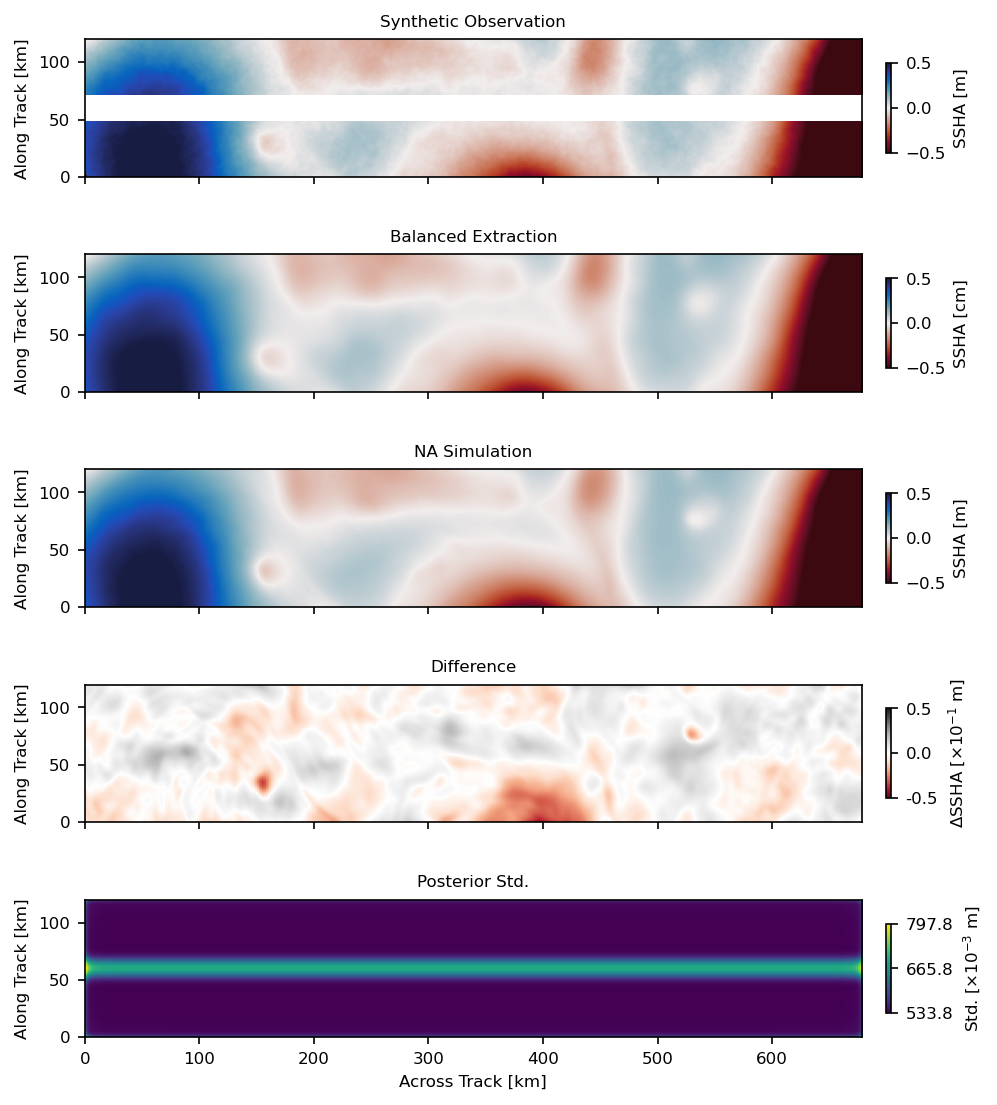

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from scipy.ndimage import gaussian_filter

index = 40
cmap = 'cmo.balance_r'
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]
vmin = -0.5 
vmax = 0.5
fsize = 8

# Reshape to 2D (note: imshow expects [rows, cols] = [nyt, nxt])
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssha_full[index]#  - np.nanmean(karin_NA.ssh_orig[index])
h_truth_map = h_truth[:, 4:64]
ssha_diff = h_truth_map - ht_map

# Plot
fig, axs = plt.subplots(5, 1, figsize=(7, 9), sharex=True, dpi=150)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(karin_NA.ssh_noisy[index].reshape(nyt, nxt).T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[0].scatter(xnn * 1e-3, ynn * 1e-3, c=nadir_NA.ssha[index][mask_n], s=3,
               cmap=cmap, edgecolor="none", vmin=vmin, vmax=vmax)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [m]', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(ht_map.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [cm]', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(h_truth_map.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [m]', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(ssha_diff.T, origin='lower', cmap='RdGy', aspect='equal',
                    extent=extent, vmin = 0.1 * vmin, vmax = 0.1 * vmax)
axs[3].set_title('Difference', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$\Delta$SSHA [$\times 10^{-1}$ m]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e1:.1f}")
cbar.update_ticks()


# Panel 5 posterior variance
im4 = axs[4].imshow(np.sqrt(posterior_variance_field[:, :]).T, origin='lower', cmap='viridis', aspect='equal', vmin = 0.0, vmax = 0.05,
                    extent=extent)
axs[4].set_title('Posterior Std.', fontsize=fsize)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.set_label(r'Std. [$\times 10^{-3}$ m]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e3:.1f}")
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()


# Axis labels and ticks
axs[4].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('ssh_extraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np

# --- Residual (Panel d) ---
# Mask NaNs if any
valid = np.isfinite(ssha_diff)
residual_flat = ssha_diff[valid]

# RMS error
rms_error = np.sqrt(np.mean(residual_flat**2))

# Typical local range (95% interval ~ covers "typical" differences)
low, high = np.percentile(residual_flat, [2.5, 97.5])

print("=== Panel (d): Residual Differences ===")
print(f"RMS Error: {rms_error:.4f} m")
print(f"Typical Local Differences (±95% range): {low:.4f} m  to  {high:.4f} m")

# --- Posterior Std (Panel e) ---
posterior_std = np.sqrt(posterior_variance_field)
posterior_valid = posterior_std[np.isfinite(posterior_std)]

print("\n=== Panel (e): Posterior Std ===")
print(f"Mean Std: {np.mean(posterior_valid):.4e} m")
print(f"Min Std:  {np.min(posterior_valid):.4e} m")
print(f"Max Std:  {np.max(posterior_valid):.4e} m")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import importlib
import JWS_SWOT_toolbox as swot
importlib.reload(swot) 

def fill_nans_rowwise(field): # fills the gap with values for the derivatives
    f = np.array(field, dtype=float)
    nrows, ncols = f.shape
    x = np.arange(ncols)

    for i in range(nrows):
        row = f[i]
        good = ~np.isnan(row)
        ngood = good.sum()
        if ngood == 0:
            continue  # leave as NaN
        elif ngood == 1:
            f[i, :] = row[good][0]  # nearest fill
        else:
            f[i, np.isnan(row)] = np.interp(x[np.isnan(row)], x[good], row[good])
    return f

field = karin_NA.ssh_noisy[index].reshape(nyt, nxt).copy().astype(float)
nan_mask = np.isnan(field)
field_filled = fill_nans_rowwise(field)

cmap = 'YlGnBu_r'
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]
vmin = 0
vmax = 1e-5  # for gradients

# Reshape to 2D
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssha_full[index]
h_truth_map = gaussian_filter(h_truth[:, 4:64], sigma=0.5)

# Gradients
# g_obs = swot.compute_gradient(karin_NA.ssh_noisy[index].reshape(nyt, nxt), karin_NA.dx, karin_NA.dy)
# g_recon = swot.compute_gradient(ht_map, karin_NA.dx, karin_NA.dy)
# g_truth = swot.compute_gradient(h_truth_map, karin_NA.dx, karin_NA.dy)
# g_diff = swot.compute_gradient(h_truth_map - ht_map, karin_NA.dx, karin_NA.dy)

# Compute the geostrophic velocity instead
lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), ht_map.shape[0])
_, _, g_obs = swot.compute_geostrophic_velocity(karin_NA.ssh_noisy[index].reshape(nyt, nxt), karin_NA.dx, karin_NA.dy, lats)
_, _, g_obs = swot.compute_geostrophic_velocity(field_filled, karin_NA.dx, karin_NA.dy, lats)
g_obs[nan_mask] = np.nan
_, _, g_recon = swot.compute_geostrophic_velocity(ht_map, karin_NA.dx, karin_NA.dy, lats)
_, _, g_truth = swot.compute_geostrophic_velocity(h_truth, karin_NA.dx, karin_NA.dy, lats)
g_truth = g_truth[:, 4:64]
g_diff = g_truth - g_recon

# Plot
fig, axs = plt.subplots(5, 1, figsize=(7, 9), sharex=True, dpi=200)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(g_obs.T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=0, vmax=2.0)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(g_recon.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=0, vmax=2.0)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(g_truth.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=0, vmax=2.0)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(np.abs(g_diff).T, origin='lower', cmap=cmap, aspect='equal', extent=extent , vmin=0, vmax=0.5)
axs[3].set_title('Difference Magnitude', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$|\Delta |{\bf u}_g||$ [ms$^{-1}$]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e0:.1f}")
cbar.update_ticks()


# Panel 5 posterior variance
im4 = axs[4].imshow(std_u.T, origin='lower', cmap='viridis', aspect='equal', vmin = 0.06, vmax = 0.1, extent=extent)
axs[4].set_title('Posterior Std.', fontsize=fsize)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.set_label(r'Std. $u_g$ [$\times 10^{-1}$ms$^{-1}$]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e1:.1f}")
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()


# Axis labels and ticks
axs[4].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('grad_extraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter  # add once at top
import JWS_SWOT_toolbox as swot
importlib.reload(swot) 

# Compute the geostrophic vorticity 
cmap = cmocean.cm.curl
vmin = -1
vmax = 1

# Reshape SSH fields to 2D
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssha_full[index]
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]

## Vorticity fields
lats = np.linspace(np.nanmin(karin_NA.lat[index]), np.nanmax(karin_NA.lat[index]), nyt)

# Compute geostrophic vorticies 
vort_obs = swot.compute_geostrophic_vorticity(field_filled, karin_NA.dx, karin_NA.dy, lats)
vort_obs[nan_mask] = np.nan
vort_recon = swot.compute_geostrophic_vorticity(ht_map, 2000, 2000, lats)
vort_truth = swot.compute_geostrophic_vorticity(h_truth, 2000, 2000, lats)
#vort_truth = gaussian_filter(vort_truth, sigma=0.5, mode='nearest')  # tiny smooth (σ in grid cells)
vort_truth = vort_truth[:, 4:64]
vort_diff = vort_truth - vort_recon

# Plot
fig, axs = plt.subplots(5, 1, figsize=(7, 9), sharex=True, dpi=200)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(vort_obs.T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=10*vmin, vmax=10*vmax)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(vort_recon.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(vort_truth.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(vort_diff.T, origin='lower', cmap='RdGy', aspect='equal', 
                    extent=extent , vmin=vmin, vmax=vmax)
axs[3].set_title('Difference', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$\zeta / f$', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()

# Panel 5 posterior variance
im4 = axs[4].imshow(std_zeta.T, origin='lower', cmap='viridis', aspect='equal', 
                    extent=extent, vmin = 0.5, vmax = 0.65)
axs[4].set_title('Posterior Std.', fontsize=fsize)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.set_label(r'Std. $\zeta / f$', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()

# Axis labels and ticks
axs[4].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('vort_extraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from matplotlib.offsetbox import AnchoredText

# Flatten and remove NaNs
vals = vort_truth.ravel()
vals = vals[~np.isnan(vals)]
vals_recon = vort_recon.ravel()
vals_recon = vals_recon[~np.isnan(vals_recon)]
vals_synth = vort_obs.ravel()
vals_synth = vals_synth[~np.isnan(vals_synth)]

# Function to compute statistics with bootstrap standard deviations
def compute_stats_with_std(data, n_bootstrap=1000):
    # Original statistics
    centroid = np.mean(data)
    skewness = skew(data)
    kurt = kurtosis(data, fisher=True)
    
    # Bootstrap to estimate standard deviations
    n_samples = len(data)
    centroids = []
    skewnesses = []
    kurts = []
    
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n_samples, replace=True)
        centroids.append(np.mean(bootstrap_sample))
        skewnesses.append(skew(bootstrap_sample))
        kurts.append(kurtosis(bootstrap_sample, fisher=True))
    
    centroid_std = np.std(centroids)
    skew_std = np.std(skewnesses)
    kurt_std = np.std(kurts)
    
    return centroid, centroid_std, skewness, skew_std, kurt, kurt_std

# Compute histograms
n_bins = 100
hist, edges = np.histogram(vals, bins=n_bins, density=True)
hist_recon, _ = np.histogram(vals_recon, bins=edges, density=True)  # Fixed variable name
hist_synth, _ = np.histogram(vals_synth, bins=edges, density=True)   # Fixed variable name
centers = 0.5 * (edges[:-1] + edges[1:])

# Compute statistics with standard deviations
centroid_sim, centroid_sim_std, skew_sim, skew_sim_std, kurt_sim, kurt_sim_std = compute_stats_with_std(vals)
mode_sim = centers[np.argmax(hist)]        # x-value of the peak

centroid_recon, centroid_recon_std, skew_recon, skew_recon_std, kurt_recon, kurt_recon_std = compute_stats_with_std(vals_recon)
mode_recon = centers[np.argmax(hist_recon)]

centroid_synth, centroid_synth_std, skew_synth, skew_synth_std, kurt_synth, kurt_synth_std = compute_stats_with_std(vals_synth)
mode_synth = centers[np.argmax(hist_synth)]  # Added synth statistics

# Plot PDFs
plt.figure(figsize=(7, 4), dpi=200)  # Made wider to accommodate annotation
plt.plot(centers, hist_recon, 'b-', lw=2, label='Balanced Ext.')
plt.plot(centers, hist_synth, 'r-', lw=2, label='Synthetic Obs.')
plt.plot(centers, hist, 'k-', lw=2, label='NA Sim.')
plt.axvline(0, color='grey', linestyle='--', linewidth=1)

# Labels & title
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')

# Legend in upper right
plt.legend(loc='upper right', fontsize=9.5)
plt.xlim(-2.5, 2.5)

# Add statistics as text outside the plot area
textstr = (
    f"NA Simulation:\n"
    f"  centroid = {centroid_sim:.3f} ± {centroid_sim_std:.3f}\n"
    f"  skewness = {skew_sim:.3f} ± {skew_sim_std:.3f}\n"
    f"  kurtosis = {kurt_sim:.3f} ± {kurt_sim_std:.3f}\n\n"
    f"Balanced Extraction:\n"
    f"  centroid = {centroid_recon:.3f} ± {centroid_recon_std:.3f}\n"
    f"  skewness = {skew_recon:.3f} ± {skew_recon_std:.3f}\n"
    f"  kurtosis = {kurt_recon:.3f} ± {kurt_recon_std:.3f}\n\n"
    # f"Synth:\n"
    # f"  centroid = {centroid_synth:.3f} ± {centroid_synth_std:.3f}\n"
    # f"  skewness = {skew_synth:.3f} ± {skew_synth_std:.3f}\n"
    # f"  kurtosis = {kurt_synth:.3f} ± {kurt_synth_std:.3f}"
)

# Method 1: Using text() with transform coordinates
plt.text(1.05, 0.99, textstr, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=9.5,
         bbox=dict(boxstyle='square', facecolor='white', alpha=0.0))

bin_size = edges[1] - edges[0]
print(f"Bin size: {bin_size:.4f}")

# Adjust layout to make room for the annotation
plt.subplots_adjust(right=0.65)  # Leave room on the right for the statistics box
plt.savefig('pdf_cyclon.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Across-track coordinate in km
x_km = np.arange(nxt) * karin_NA.dx * 1e-3

# --- 1. SSH ---
ssh_diff_std = np.nanstd(h_truth_map - ht_map, axis=0)
ssh_posterior_std = np.mean(np.sqrt(posterior_variance_field[:, :]), axis=0)

# --- 2. Gradient magnitude ---
grad_diff_std = np.nanstd(g_truth - g_recon, axis=0)
grad_posterior_std = np.mean(std_u, axis=0)
grad_posterior_std_v = np.mean(std_v, axis=0)

# --- 3. Vorticity ---
vort_diff_std = np.nanstd(vort_truth - vort_recon, axis=0)
vort_posterior_std = np.mean(std_zeta, axis=0)


fig, axs = plt.subplots(3, 1, figsize=(5, 10.5), dpi=150, sharex=True, sharey=False)

# Increase vertical spacing manually
fig.subplots_adjust(hspace=0.4)

# Panel 1: SSH
axs[0].plot(x_km, ssh_diff_std*100, label=r'$\Delta$SSHA Std.', linewidth=1.5)
axs[0].plot(x_km, ssh_posterior_std*100, '--', label='SSHA Posterior Std.', linewidth=1.5)
axs[0].set_title('SSHA')
axs[0].set_ylabel('Std. [cm]')
axs[0].set_ylim(0.3, 1)
axs[0].legend(fontsize=10)

# Panel 2: Gradient magnitude
axs[1].plot(x_km, grad_diff_std, label=r'$\Delta|{\bf u}_g|$ Std.', linewidth=1.5)
axs[1].plot(x_km, grad_posterior_std, '--', label=r'$u_g$ Posterior Std.', linewidth=1.5)
#axs[1].plot(x_km, grad_posterior_std_v, '--', label=r'$v_g$ Posterior Std.', linewidth=1.5)
axs[1].set_title('Geostrophic Speed')
axs[1].set_ylabel(r'Std. [ms$^{-1}$] ')
axs[1].set_ylim(0.05, 0.12)
axs[1].legend(fontsize=10)

# Panel 4: Vorticity
axs[2].plot(x_km, vort_diff_std, label=r'$\Delta \zeta$ Std.', linewidth=1.5)
axs[2].plot(x_km[1:-1], vort_posterior_std[1:-1], '--', label=r'$\zeta$ Posterior Std.', linewidth=1.5)
axs[2].set_title('Geostrophic Vorticity')
axs[2].set_xlabel('Across Track [km]')
axs[2].set_ylabel(r'Std. [$1/f \,$]')
axs[2].set_ylim(0.4, 0.75)
axs[2].legend(fontsize=10)
plt.savefig('cross_track_std.pdf', bbox_inches='tight')
plt.show()


## Old

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# --- Prepare data ---

# Estimated SSH
ht_map = ht_NA_sim.reshape(nxt, nyt)  # (ny, nx)

# Original simulation (truth)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])  # give ssha of the original simulation

# Noisy observations (masked KaRIn + Nadir)
ssh_k_flat = karin_NA.ssh_noisy[index].flatten(order='C')
mask_k_flat = mask_k.flatten(order='C')
obs_k = ssh_k_flat[mask_k_flat]

# Shared color scale
vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

# Gradient fields
grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

# Vorticity fields
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nxt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), h_truth.shape[0])
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats)

# --- Create figure layout: 4 rows × 2 columns ---
fig, axes = plt.subplots(4, 2, figsize=(15, 13), sharex='col',
                         gridspec_kw={"hspace": 0.4, "wspace": 0.1})

# ===== Row 0: Observations =====
sc0 = axes[0, 0].scatter(
    ykk * 1e-3, xkk * 1e-3, c=obs_k, s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].scatter(
    ynn * 1e-3, xnn * 1e-3, c=nadir_NA.ssh[index][mask_n], s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].set_title("SWOT Noise NA Simulation", fontsize=11)
axes[0, 0].set_ylabel("Across-track (km)")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.7, pad=0.02)

im_obs_truth = axes[0, 1].imshow(
    h_truth.T, origin="lower",
    extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
    cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto'
)
axes[0, 1].set_title("Original NA Simulation")
fig.colorbar(im_obs_truth, ax=axes[0, 1], shrink=0.7, pad=0.02)

# ===== Row 1: SSH maps =====
im0 = axes[1, 0].imshow(ht_map, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Estimated SSH")
axes[1, 0].set_ylabel("Across-track (km)")
fig.colorbar(im0, ax=axes[1, 0], shrink=0.7, pad=0.02)

im1 = axes[1, 1].imshow(h_truth, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.7, pad=0.02)

# ===== Row 2: Gradient maps =====
g0 = axes[2, 0].imshow(grad_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 0].set_title("Gradient (Estimated)")
axes[2, 0].set_ylabel("Across-track (km)")
axes[2, 0].set_xlabel("Along-track (km)")
fig.colorbar(g0, ax=axes[2, 0], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[2, 1].imshow(grad_true, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 1].set_title("Gradient (True)")
axes[2, 1].set_xlabel("Along-track (km)")
fig.colorbar(g1, ax=axes[2, 1], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

# ===== Row 3: Vorticity maps =====
v0 = axes[3, 0].imshow(geo_vort_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 0].set_title("Geostrophic Vorticity (Estimated)")
axes[3, 0].set_ylabel("Across-track (km)")
axes[3, 0].set_xlabel("Along-track (km)")
fig.colorbar(v0, ax=axes[3, 0], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

v1 = axes[3, 1].imshow(geo_vort_true, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 1].set_title("Geostrophic Vorticity (True)")
axes[3, 1].set_xlabel("Along-track (km)")
fig.colorbar(v1, ax=axes[3, 1], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

plt.tight_layout()
plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# --- Reshape and prepare ---
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])

obs_k = karin_NA.ssh_noisy[index][mask_k]
obs_n = nadir_NA.ssh[index][mask_n]

vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nyt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats)

extent = (0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3)  # (x, y) in km

# --- Transposed figure layout: 2 rows × 4 columns ---
fig, axes = plt.subplots(2, 4, figsize=(20, 20), sharey=False, sharex=False,
                         gridspec_kw={"hspace": 0.2, "wspace": 0.2})

# ---- Column 0: Observations ----
sc1 = axes[0, 0].scatter(xkk * 1e-3, ykk * 1e-3, c=ssh_k_obs, cmap=cmocean.cm.balance,
                  s=5, label='KaRIn SSH', edgecolor="none")

# Nadir observations colored by SSH
sc2 = axes[0, 0].scatter(xnn * 1e-3, ynn * 1e-3, c=ssh_n_obs, cmap=cmocean.cm.balance,
                  s=5, label='Nadir SSH', edgecolor="none", marker='x')
axes[0, 0].set_title("SWOT Noisy Obs")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.8, pad=0.02)

im_obs_truth = axes[1, 0].imshow(h_truth, origin="lower", extent=extent,
                                 cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Original Noisy Obs")
fig.colorbar(im_obs_truth, ax=axes[1, 0], shrink=0.8, pad=0.02)

# ---- Column 1: SSH ----
im0 = axes[0, 1].imshow(ht_map, origin="lower", extent=extent,
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[0, 1].set_title("Estimated SSH")
fig.colorbar(im0, ax=axes[0, 1], shrink=0.8, pad=0.02)

im1 = axes[1, 1].imshow(h_truth, origin="lower", extent=extent,
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.8, pad=0.02)

# ---- Column 2: Gradients ----
g0 = axes[0, 2].imshow(grad_est, origin="lower", extent=extent,
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[0, 2].set_title("Gradient (Estimated)")
fig.colorbar(g0, ax=axes[0, 2], shrink=0.8, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[1, 2].imshow(grad_true, origin="lower", extent=extent,
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[1, 2].set_title("Gradient (True)")
fig.colorbar(g1, ax=axes[1, 2], shrink=0.8, pad=0.02, label=r"$\nabla(SSH)$")

# ---- Column 3: Vorticity ----
v0 = axes[0, 3].imshow(geo_vort_est, origin="lower", extent=extent,
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[0, 3].set_title("Vorticity (Estimated)")
fig.colorbar(v0, ax=axes[0, 3], shrink=0.8, pad=0.02, label=r"$\zeta / f$")

v1 = axes[1, 3].imshow(geo_vort_true, origin="lower", extent=extent,
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[1, 3].set_title("Vorticity (True)")
fig.colorbar(v1, ax=axes[1, 3], shrink=0.8, pad=0.02, label=r"$\zeta / f$")

# --- Labels ---
for ax in axes[1, :]:
    ax.set_xlabel("Across-track (km)")
for ax in axes[:, 0]:
    ax.set_ylabel("Along-track (km)")

plt.tight_layout()
plt.savefig("swot_diagnostics_transposed.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import xarray as xr

est_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, ht_map.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, ht_map.shape[1], 1.0) * karin.dx
}

truth_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, h_truth.T.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, h_truth.T.shape[1], 1.0) * karin.dx
}

recovered_xr = xr.DataArray(ht_map[None, :, :], coords=est_coords, dims=['sample', 'pixel', 'line'])
truth_xr     = xr.DataArray(h_truth.T[None, :, :], coords=truth_coords, dims=['sample', 'pixel', 'line'])

# Compute power spectra
spec_est  = swot.mean_power_spectrum(recovered_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])
spec_true = swot.mean_power_spectrum(truth_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])

# Trim to 1-sided spectrum
spec_est = spec_est[int(nx / 2):]
spec_true = spec_true[int(nx / 2):]

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# True and estimated SSH spectra
ax.loglog(k_km[1:], spec_true[1:], lw=2, label='NA SSHA')
ax.loglog(k_km[1:], spec_est[1:], lw=2, label='Estimated SSHA')

# NA sim & noisy spectra
ax.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, lw=2, label='Time Av. NA Sim Spectrum')
# ax.loglog(spec_ssh_noisy.freq_line * 1e3, spec_ssh_noisy, lw=2, label='NA Sim + KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_nad_noisy, lw=2, label='NA Sim + Nadir Noise')

# SWOT observations
# ax.loglog(karin.wavenumbers * 1e3, karin.spec_alongtrack_av, lw=2, label='SWOT KaRIn SSHA')
# ax.loglog(nadir.wavenumbers * 1e3, nadir.spec_alongtrack_av, lw=2, label='SWOT Nadir SSHA')

ax.loglog(k_km[1:], spunbalanced[1:], lw=2, label='Unbalanced Model') # from above model
ax.loglog(k_km[1:], spbalanced, '-', lw=2, label='Balanced Model') # from above model
ax.loglog(k_nadir[1:]*1e3, spnoise_nadir[1:], label = r'Nadir Noise Model')

# # Synthetic noise models
# ax.loglog(k_km, spec_eta_k, ':', lw=2, label='Synthetic KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_eta_n, ':', lw=2, label='Synthetic Nadir Noise')

# Axes formatting
ax.set_xlabel("Wavenumber (cpkm)", fontsize=12)
ax.set_ylabel("PSD (m² / cpkm)", fontsize=12)
ax.set_ylim([1e-6, 1e5])
ax.set_title("Power Spectra Comparison", fontsize=13)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

### Loop over all frames and save the data  

Note here we are saving now a 64 grid rather than the original 60 grid points

We also get some threshold of Nans, like if 30\% or more of the data are NaN then reject it. Just the gap is 0.16 (16%) so if we set threshold to 30% then we are saying the KaRIn data should have no more than ~15% of NaN values

In [ ]:
import pickle
import numpy as np
from joblib import Parallel, delayed
os.environ["NUMEXPR_MAX_THREADS"] = "8" # With 128GB of RAM 4 works

name = "NA_sim"
run_dir = f"./NA_sim_outputs/{name}_P{pass_num:03d}"
os.makedirs(run_dir, exist_ok=True)

print("dirs made")

# ---- Function for processing a single frame ----
def process_frame(index):
    try:
        print(index)
        # Build masks
        mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
        mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])
        
        # Obs values
        h_obs = np.concatenate((
            karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
            nadir_NA.ssh_noisy[index][mask_n]
        ))
        
        xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True)
        
        # Estimate signal
        #ht_NA_sim = swot.estimate_signal_on_target(c, yt, xt, xobs, yobs, C_obs, N_obs, h_obs) # old one
        ht_NA_sim = swot.estimate_signal_on_target_fast(R, C, N, h) # faster with covariance outside the loop
        ht_map = ht_NA_sim.reshape(nyt, nxt)

        lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), nyt)
        gvort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), karin_NA.dx, karin_NA.dy, lats)

        basename = f"P{pass_num:03d}_C{shared_cycles[index]:03d}_{index:03d}"
        filename_SSH = os.path.join(run_dir, f"{basename}_SSH.npy")
        filename_gvort = os.path.join(run_dir, f"{basename}_gvort.npy")
        np.save(filename_SSH, ht_map)
        np.save(filename_gvort, gvort)
        print(f"Frame {index:03d} → saved `{filename_SSH}`")
        
        return filename_SSH
    except Exception as e:
        print(f"Skipping Frame: {index:03d} could not be processed: {e}")
        return None

#process_frame(1)

# ---- Save the karin and nadir classes ----
with open(os.path.join(run_dir, f'karin_class_P{pass_num:03d}.pkl'), 'wb') as f:
    pickle.dump(karin_NA, f)
with open(os.path.join(run_dir, f'nadir_class_P{pass_num:03d}.pkl'), 'wb') as f:
    pickle.dump(nadir_NA, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")

# ---- Run in parallel ----
n_frames = karin_NA.ssha.shape[0]
print(n_frames)
results = Parallel(n_jobs=2, backend='loky')(
    delayed(process_frame)(idx) for idx in range(n_frames)
)


In [ ]:
# extra save Pickle files

with open(os.path.join(run_dir, f'karin_class_SWOT.pkl'), 'wb') as f:
    pickle.dump(karin_NA, f)
with open(os.path.join(run_dir, f'nadir_class_SWOT.pkl'), 'wb') as f:
    pickle.dump(nadir_NA, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")